In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
import time
import pandas as pd

In [2]:
SVHN_train = torchvision.datasets.SVHN('/home/vbhandaru/PycharmProjects/FinalProject/',split='train', download=True, transform=torchvision.transforms.ToTensor())
SVHN_test = torchvision.datasets.SVHN('/home/vbhandaru/PycharmProjects/FinalProject/', split='test', download=True, transform=torchvision.transforms.ToTensor())

Using downloaded and verified file: /home/vbhandaru/PycharmProjects/FinalProject/train_32x32.mat
Using downloaded and verified file: /home/vbhandaru/PycharmProjects/FinalProject/test_32x32.mat


In [3]:
#Separate training into training and validation
print(len(SVHN_train), len(SVHN_test))
a = list(range(len(SVHN_train)))
np.random.seed(5)
np.random.shuffle(a)
val_indices = a[0:7000]
train1_indices = a[7000:]
val = [SVHN_train[i] for i in val_indices]
train1 = [SVHN_train[i] for i in train1_indices]
print(len(val), len(train1))

(73257, 26032)
(7000, 66257)


In [18]:
def conv_train(train_data=SVHN_train, num_epochs=10, batch_size=100, val_data=None, validate=0):
    start = time.time()
    criterion = torch.nn.CrossEntropyLoss()
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    if validate==1:
        val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    for epoch in range(num_epochs):
        if epoch%10==0: print("epoch ", epoch)
        model.train()
        for data in train_loader:
            inputs, labels = data
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        if validate==1:
            model.eval()
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs = Variable(inputs.cuda())
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                if i==0:
                    df = pd.DataFrame({'Predicted':list(preds), 'Actual': list(labels)})
                if i>0:
                    df1 = pd.DataFrame({'Predicted':list(preds), 'Actual': list(labels)})
                    df = pd.concat([df, df1])
            epoch_acc = accuracy_score(df['Actual'], df['Predicted'])
            acc1 = pd.DataFrame({'Epoch': [epoch], 'Accuracy': [epoch_acc] })
            if epoch==0:
                acc = acc1
            else:
                acc = pd.concat([acc, acc1])
            model.eval()
            for i, data in enumerate(train_loader):
                inputs, labels = data
                inputs = Variable(inputs.cuda())
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                if i==0:
                    df_train = pd.DataFrame({'Predicted':list(preds), 'Actual': list(labels)})
                if i>0:
                    df1_train = pd.DataFrame({'Predicted':list(preds), 'Actual': list(labels)})
                    df_train = pd.concat([df_train, df1_train])
            epoch_acc_train = accuracy_score(df_train['Actual'], df_train['Predicted'])
            acc1_train = pd.DataFrame({'Epoch': [epoch], 'Accuracy': [epoch_acc_train] })
            if epoch==0:
                acc_train = acc1_train
            else:
                acc_train = pd.concat([acc_train, acc1_train])
    end = time.time()
    t1 = end-start
    print str(t1) + ' seconds'
    if validate==1: 
        acc = acc.rename(columns={'Accuracy': 'Validation accuracy'}).merge(acc_train.rename(columns={'Accuracy': 'Training accuracy'}), on='Epoch').set_index('Epoch')
        acc.plot(title='Training and validation accuracy')
        return acc 

In [5]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    

('epoch ', 0)
('epoch ', 10)
('epoch ', 20)
('epoch ', 30)
('epoch ', 40)
('epoch ', 50)
('epoch ', 60)
('epoch ', 70)
('epoch ', 80)
('epoch ', 90)
299.856040001 seconds


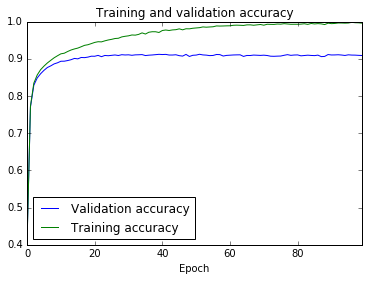

In [19]:
model = torch.nn.Sequential(
        torch.nn.Conv2d(3,20,5),
        torch.nn.MaxPool2d(2, stride=2),
        torch.nn.ReLU(),
        torch.nn.Conv2d(20,50,5),
        torch.nn.MaxPool2d(2, stride=2),
        torch.nn.ReLU(),
        torch.nn.Dropout2d(0.25),
        Flatten(),
        torch.nn.Linear(1250, 500), 
        torch.nn.ReLU(),
        torch.nn.Linear(500, 10), 
        torch.nn.LogSoftmax()
        ).cuda() 
optimizer =torch.optim.Adam(model.parameters(),lr=0.001)
acc = conv_train(train_data=train1, num_epochs=100, batch_size=1000, val_data=val, validate=1)

In [14]:
def conv_test(batch_size=1000, testds=SVHN_test, report=0):
    model.eval()
    test_loader = torch.utils.data.DataLoader(testds, batch_size=batch_size, shuffle=True)
    for i,data in enumerate(test_loader):
        inputs, labels = data
        inputs = Variable(inputs.cuda())
        labels = labels.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        if i==0:
            df = pd.DataFrame({'Predicted':list(preds), 'Actual': list(labels)})
        if i>0:
            df1 = pd.DataFrame({'Predicted':list(preds), 'Actual': list(labels)})
            df = pd.concat([df, df1])
    print(testds)
    if report==1:
        print(classification_report(df['Actual'], df['Predicted']))
    print(accuracy_score(df['Actual'], df['Predicted']))
    return df

In [20]:
ctest_dropout = conv_test(report=1)

             precision    recall  f1-score   support

          0       0.89      0.91      0.90      1744
          1       0.92      0.94      0.93      5099
          2       0.94      0.92      0.93      4149
          3       0.87      0.84      0.85      2882
          4       0.88      0.93      0.90      2523
          5       0.91      0.90      0.90      2384
          6       0.88      0.88      0.88      1977
          7       0.92      0.89      0.91      2019
          8       0.90      0.83      0.86      1660
          9       0.79      0.89      0.84      1595

avg / total       0.90      0.90      0.90     26032

0.8987784265519361


In [25]:
pd.crosstab(ctest_dropout['Actual'], ctest_dropout['Predicted'])

Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,1590,22,10,19,9,7,38,5,11,33
1,43,4780,47,32,105,11,15,47,7,12
2,14,50,3823,70,58,15,17,53,21,28
3,18,95,43,2407,25,77,20,12,36,149
4,16,60,29,19,2334,6,10,15,11,23
5,7,15,19,84,25,2135,54,4,7,34
6,41,16,11,27,33,44,1747,5,31,22
7,5,118,41,31,16,3,5,1791,2,7
8,22,13,10,51,29,27,73,4,1373,58


('epoch ', 0)
('epoch ', 10)
('epoch ', 20)
('epoch ', 30)
('epoch ', 40)
('epoch ', 50)
('epoch ', 60)
('epoch ', 70)
('epoch ', 80)
('epoch ', 90)
299.101773024 seconds


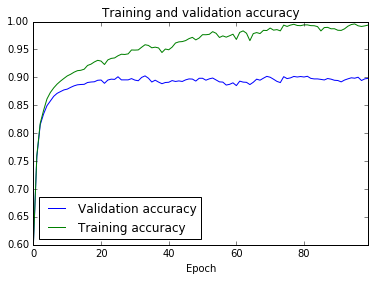

In [21]:
model = torch.nn.Sequential(
        torch.nn.Conv2d(3,20,5),
        torch.nn.MaxPool2d(2, stride=2),
        torch.nn.ReLU(),
        torch.nn.Conv2d(20,50,5),
        torch.nn.MaxPool2d(2, stride=2),
        torch.nn.ReLU(),
        Flatten(),
        torch.nn.Linear(1250, 500), 
        torch.nn.ReLU(),
        torch.nn.Linear(500, 10), 
        torch.nn.LogSoftmax()
        ).cuda() 
optimizer =torch.optim.Adam(model.parameters(),lr=0.001)
acc_nodropout = conv_train(train_data=train1, num_epochs=100, batch_size=1000, val_data=val, validate=1)

In [22]:
ctest_nodropout = conv_test(report=1)

             precision    recall  f1-score   support

          0       0.89      0.89      0.89      1744
          1       0.90      0.94      0.92      5099
          2       0.93      0.91      0.92      4149
          3       0.86      0.83      0.84      2882
          4       0.88      0.91      0.90      2523
          5       0.93      0.85      0.89      2384
          6       0.85      0.86      0.85      1977
          7       0.85      0.92      0.88      2019
          8       0.85      0.82      0.83      1660
          9       0.86      0.83      0.85      1595

avg / total       0.89      0.89      0.89     26032

0.8861017209588199
